In [1]:
import torch
import torch.nn as nn
import torchvision
from datetime import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt

d:\code\PytorchNonstop\ComputerVision\MNISTBasic\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Device configuration

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Hyperparameters

In [3]:
num_epochs = 10
batch_size = 100
learning_rate = 0.01
num_classes = 10

# MNIST dataset

In [4]:
train_dataset = torchvision.datasets.MNIST(root="../data/",
                                           train=True,
                                           transform=torchvision.transforms.ToTensor(),
                                           download=True)
test_dataset = torchvision.datasets.MNIST(root="../data/",
                                          train=True,
                                          transform=torchvision.transforms.ToTensor(),
                                          download=False)

# Data loader

In [5]:
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size,
                                               shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                              batch_size=batch_size,
                                              shuffle=False)                                               

In [6]:
examples = enumerate(train_dataloader)
batch_idx, (example_data, example_labels) = next(examples)
print(f"Batch index {batch_idx}")
print(f"Batch train data shape {example_data.shape}")
print(f"Batch train labels shape {example_labels.shape}")

Batch index 0
Batch train data shape torch.Size([100, 1, 28, 28])
Batch train labels shape torch.Size([100])


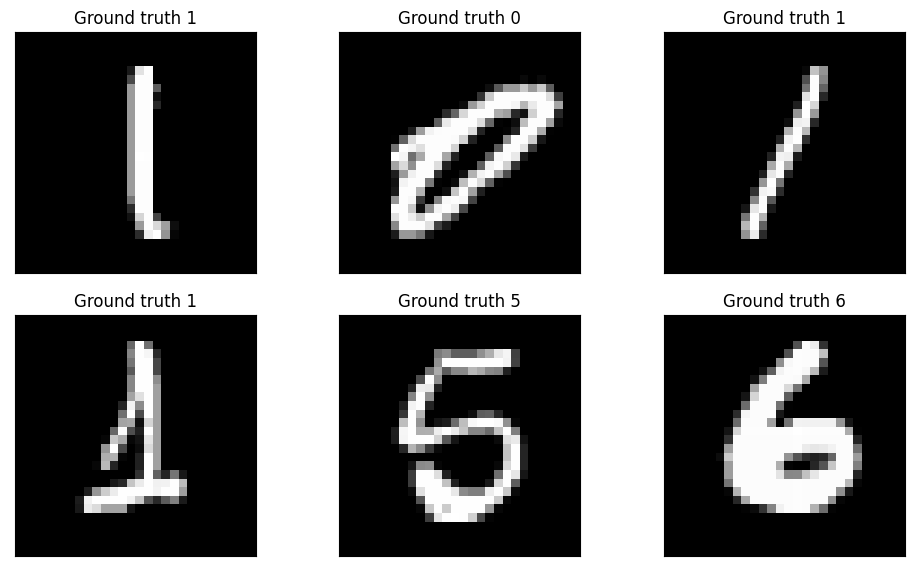

In [7]:
plt.figure(figsize=[10, 6])
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap="gray", interpolation=None)
    plt.title(f"Ground truth {example_labels[i]}")
    plt.xticks([])
    plt.yticks([])

# Convolutional Neural Network

In [12]:
class ConvNet(nn.Module):

    def __init__(self, num_classes=10):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc = nn.Linear(7*7*32, num_classes)
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [13]:
model = ConvNet(num_classes=num_classes).to(device)

# Loss and optimizer

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model

In [17]:
for epoch in range(num_epochs):
    with tqdm(train_dataloader, unit="epoch", leave=True, position=0) as train_dataloader_tqdm:
        for images, labels in train_dataloader_tqdm:
            train_dataloader_tqdm.set_description(f"Epoch {epoch+1}")
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_dataloader_tqdm.set_postfix(loss=loss.item())

Epoch 10: 100%|██████████| 600/600 [01:10<00:00,  8.51epoch/s, loss=0.0371]  


# Test the model

In [18]:
model.eval()
with torch.no_grad():
    total = 0
    correct = 0
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        __, predicted = torch.max(outputs, 1)

        total += len(labels)
        correct += (predicted == labels).sum().item()

    print(f"Test accuracy of the model on the 10000 test images: {100 * correct / total:.2f}")

Test accuracy of the model on the 10000 test images: 99.61


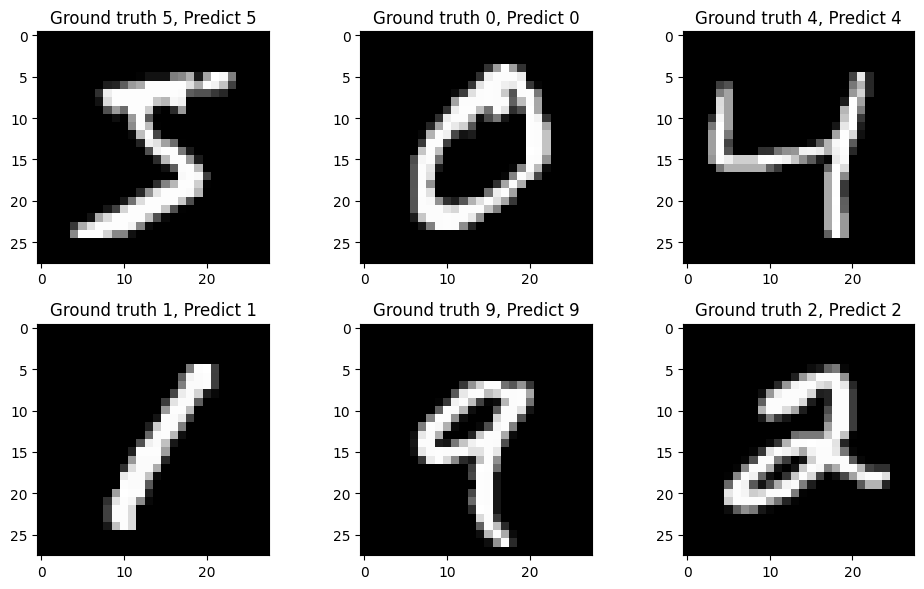

In [20]:
examples = enumerate(test_dataloader)
batch_idx, (example_data, example_labels) = next(examples)
__, predicted = torch.max(model(example_data.to(device)), 1)

plt.figure(figsize=[10, 6])
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap="gray", interpolation=None)
    plt.title(f"Ground truth {example_labels[i]}, Predict {predicted[i]}")    

# Save the model checkpoint

In [23]:
filename = "../save/" + datetime.now().strftime("model_%d-%m-%y-%H_%M_%S.ckpt")
torch.save(model.state_dict(), filename)